# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [3]:
import io
import os
import numpy as np
import scipy

# Graphic Packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Sklearn packages
import sklearn.linear_model as sklin_mod
import sklearn.model_selection as skmod_selec
import sklearn.ensemble as skens
import sklearn.decomposition as skdeco
import sklearn.svm as sksvm
import sklearn.naive_bayes as sknb

# Progress bar
import tqdm as tqdm

In [4]:
PATH_TO_DATA = "./Data/"

# 1) Monolingual (English) word embeddings 

In [5]:
class Word2vec():
    def __init__(self, fname, nmax=100000, classification=False):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        for i, k in enumerate(self.word2id.keys()): self.word2id[k] = i
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
        
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # Scores
        scores = np.array([self.score(wi, w) for wi in self.word2id.keys()])
        
        # K most similar words: self.score  -  np.argsort 
        idx_K_most_similar = np.argsort(scores)[-(K+1):-1]
        K_most_similar = np.array([self.id2word[k] for k in idx_K_most_similar])
        
        return K_most_similar

    def score(self, w1, w2):
        
        # Extract vector value
        vw1 = self.word2vec[w1]
        if type(w2) == str:
            vw2 = self.word2vec[w2]
        else:
            vw2 = w2
        
        # cosine similarity: np.dot  -  np.linalg.norm
        score = np.dot(vw1.T, vw2)
        score /= (np.linalg.norm(vw1) * np.linalg.norm(vw2))
        
        return score

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), 
                  ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))

for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['kitties' 'feline' 'kitten' 'kitty' 'cats']
['canine' 'doggie' 'Dog' 'puppy' 'dogs']
['canines' 'doggies' 'Dogs' 'pooches' 'dog']
['berlin' 'london' 'parisian' 'Paris' 'france']
['poland' 'berlin' 'german' 'europe' 'austria']


In [7]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
        self.sentemb = {}
        
    def readInW2V(self, word):
        """Extract the value of word if present in w2v."""
         
        vec = self.w2v.word2vec.get(word, np.zeros((300)))
        return vec
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a dict of sentence embeddings
        # see TP1 for help
        
        result = np.zeros((len(sentences), 300))        
        
        for i, sent in enumerate(sentences):
            if idf is False:
                # mean of word vectors
                # assert False, 'TODO: fill in the blank'
                sums = 0
                words = sent.rstrip().split(' ')
                for w in words:
                    sums += self.readInW2V(w)
                    
                self.sentemb[sent] =  sums / len(words)
                result[i, :] = sums
                
            else:
                # idf-weighted mean of word vectors
                # assert False, 'TODO: fill in the blank'
                sums = 0
                sum_idf = 0
                words = sent.rstrip().split(' ')
                for w in words:
                    sums += idf[w] * self.readInW2V(w)
                    sum_idf += idf[w]
                
                self.sentemb[sent] =  sums / sum_idf
                result[i, :] = sums
                
        return result

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        self.encode(sentences, idf)
        self.encode([s], idf)
        
        # Scores with all the sentences
        scores = np.array([self.score(si, s) for si in self.sentemb.keys()])
        
        # K most similar
        idx_K_most_similar = np.argsort(scores)[-(K+1):-1]
        keys = list(self.sentemb.keys())
        K_most_similar = np.array([keys[k] for k in idx_K_most_similar])
        
        return K_most_similar

    def score(self, s1, s2, idf=False):
        # Extract vector value
        vs1 = self.sentemb[s1]
        vs2 = self.sentemb[s2]
        
        # cosine similarity: np.dot  -  np.linalg.norm
        score = np.dot(vs1.T, vs2)
        score /= (np.linalg.norm(vs1) * np.linalg.norm(vs2))
        
        return score
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        
        for sent in sentences:
            words = set(sent.rstrip().split(' '))
            for w in words:
                idf[w] = idf.get(w, 0) + 1
    
#         max(1, np.log10(len(sentences) / (idf[word])))

        for w in idf.keys():
            idf[w] = np.log10(len(sentences) / (idf[w]))
            
        return idf

In [ ]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
fname = os.path.join(PATH_TO_DATA, 'sentences.txt')
with io.open(fname, encoding='utf-8') as f:
    for i, line in enumerate(f):
        sentences.append(line)

# You will be evaluated on the output of the following:
print("\n------ Without IDF -------")
print("Sentence 10: ", sentences[10],
      "K most similar to sentence 10: \n",
      s2v.most_similar(sentences[10], sentences), "\n")  # BoV-mean
print("Sentence 7: ", sentences[7], "Sentence 13: ", sentences[13])
print("Score between the past two: ", s2v.score(sentences[7], sentences[13]))

# Build idf scores for each word
idf = s2v.build_idf(sentences)

print("\n\n------ With IDF -------")
print("Sentence 10: ", sentences[10], 
      "K most similar to sentence 10: \n",
      s2v.most_similar(sentences[10], sentences, idf), "\n")  # BoV-mean
print("Sentence 7: ", sentences[7], "Sentence 13: ", sentences[13])
print("Score between the past two: ", s2v.score(sentences[7], sentences[13], idf))

Loaded 200000 pretrained word vectors

------ Without IDF -------
Sentence 10:  1 smiling african american boy . 
 K most similar to sentence 10: 
 ['a girl in black hat holding an african american baby . \n'
 'an african american man is sitting . \n'
 'an afican american woman standing behind two small african american children . \n'
 'a little african american boy and girl looking up . \n'
 'an african american man smiling . \n'] 

Sentence 7:  1 man singing and 1 man playing a saxophone in a concert . 
 Sentence 13:  10 people venture out to go crosscountry skiing . 

Score between the past two:  0.5726258859719605


------ With IDF -------


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# Read the data
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

def ics(w2v_en, w2v_fr):
    """Return X, Y the matrices corresponding to the vocabs appearing in both
       word2Vec_en and word2Vec_fr."""
    
    # Initialisation of X and Y
    X = []
    Y = []
    
    # Add key if present in both word2vec
    for word_fr, vec_fr in w2v_fr.word2vec.items():
        
        # Extract vec_en if word_fr is in word2vec_en, 0 otherwise
        vec_en = w2v_en.word2vec.get(word_fr, 0)
        if type(vec_en) != int:
            X.append(vec_fr)
            Y.append(vec_en)
            
    # COnvert as array and transpose it
    X = np.array(X).T
    Y = np.array(Y).T
            
    return X, Y

# Creation of the matrices X and Y
X, Y = ics(w2v_en, w2v_fr)
print(np.shape(X), np.shape(Y))

(300, 18970) (300, 18970)


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# Compute the svd of Y * X^T
U, s, Vh = scipy.linalg.svd(np.dot(Y, X.T))

# Compute W
W = np.dot(U, Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above


# Extract a random french word
print("----French to English------")
word_fr = "lucifer" # np.random.choice(list(w2v_fr.word2vec.keys())) #saccage, éden, multiplié
vec_fr = w2v_fr.word2vec[word_fr]
print("French to translate: ", word_fr)

# Transform the french word as an english vector through W
translated_word_fr = np.dot(W, vec_fr)

# Find the K closest english words
k_en_words = w2v_en.most_similar(translated_word_fr)
print("K most similar words in english: ", k_en_words)


# Extract a random English word
print("\n----English to French------")
word_en = "participates" # beehive, forfeit, palace # np.random.choice(list(w2v_en.word2vec.keys())) 
vec_en = w2v_en.word2vec[word_en]
print("English to translate: ", word_en)

# Transform the french word as an english vector through W
translated_word_en = np.dot(W.T, vec_en)

# Find the K closest english words
k_fr_words = w2v_fr.most_similar(translated_word_en)
print("K most similar words in French: ", k_fr_words)

----French to English------
French to translate:  lucifer
K most similar words in english:  ['demonic' 'god' 'magus' 'hades' 'satan']

----English to French------
English to translate:  participates
K most similar words in French:  ['participé' 'intervenant' 'organise' 'participe' 'participant']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

***Commentaries:***

We have to be careful because some English words are present in the wiki.fr.vec database and some French words are also present in the wiki.en.vec database.

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def readSentenceClassification(fname, with_labels=True):
    """Extract the labels and the sentence in to different matrices."""

    # arrays for labels and sentences
    X = []
    Y = []
    
    # Extract the labels and sentences from fname
    with io.open(fname, encoding='utf-8') as f:
        for i, line in enumerate(f):

            X.append(line[1:])
            
            if with_labels:
                Y.append(line[0])
            
    # Convert Y as a vector
    Y = np.array(Y)
    
    # Return results
    if with_labels:
        return X, Y
    else:
        return X
    
# Load the dev, train and test dataset
X_dev, Y_dev = readSentenceClassification(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev')) 
X_train, Y_train = readSentenceClassification(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
X_test = readSentenceClassification(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'),
                                    with_labels=False) 

# Convert labels as int
Y_dev = Y_dev.astype(int)
Y_train = Y_train.astype(int)

In [12]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
bov = BoV(w2v)

# Compute the IDF
X_total = []
X_total.extend(X_dev)
X_total.extend(X_train)
X_total.extend(X_test)
idf = bov.build_idf(X_total) # False

# Encode dev dataset
# idf_dev = bov.build_idf(X_dev) # False
X_dev_encoded = bov.encode(X_dev, idf=idf)

# Encode train dataset
# idf_train = bov.build_idf(X_train) # False
X_train_encoded = bov.encode(X_train, idf=idf)

# Encode test dataset
# idf_test = bov.build_idf(X_test) # False
X_test_encoded = bov.encode(X_test, idf=idf)

Loaded 200000 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# GridSearch for the best parameters
parameters = {'fit_intercept': [False],
              'C': [10e-5], # [10 ** (i) for i in np.linspace(-5, 0, 5)],
              'penalty': ['l2'],
              'solver': ['newton-cg']}

# Model and GridSearch
log_reg = sklin_mod.LogisticRegression(multi_class='multinomial')
clf =  skmod_selec.GridSearchCV(log_reg, parameters, cv=5)

# Executes 
clf.fit(X_train_encoded, Y_train)

# Print best scores and best parameters
print("Best score: ", clf.best_score_)
print("Best parameters: ", clf.best_params_)

Best score:  0.4336376404494382
Best parameters:  {'C': 0.0001, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'newton-cg'}


***Commentaries***

We can perform also a PCA on the vectors to reduce their dimensionnality however, it reduces significantly the performance of classification.

In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Predict the labels for the testing set with the best parameters found
Y_pred = clf.predict(X_test_encoded)

# Save the labels predicted in an array
np.savetxt("./Results/logreg_bov_y_test_sst.txt", Y_pred)

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

def testModel(model, params, saving_name="random_forest"):
    """Test the accuracy of a model with a grid search."""
    
    # GridSerach on the model
    clf =  skmod_selec.GridSearchCV(model, params, cv=5)

    # Fitting
    clf.fit(X_train_encoded, Y_train)

    # Print best scores and best parameters
    print("Best score: ", clf.best_score_)
    print("Best parameters: ", clf.best_params_)

    # Predict the labels for the testing set with the best parameters found
    Y_pred = clf.predict(X_test_encoded)

    # Save the labels predicted in an array
    np.savetxt("./Results/" + saving_name + "_bov_y_test_sst.txt", Y_pred, delimiter=",")
    
## Random Forest
# GridSearch for the best parameters
# parameters = {'n_estimators': [150], #np.linspace(50, 200, 10, dtype=int),
#               'criterion': ["gini"],
#               "bootstrap": [False],
#               "oob_score": [False]}

# # Model and GridSearch
# rFC = skens.RandomForestClassifier()

## SVC
# GridSearch for the best parameters
parameters = {'C': [0.0005]
             }

# model
svc = sksvm.SVC(gamma="scale", max_iter=-1, kernel="linear")

# Computes results
testModel(svc, parameters, saving_name="XXX")

Best score:  0.42544475655430714
Best parameters:  {'C': 0.0005}


***Commentaries***:

The Random Forest Classifier performs lower than the classic logistic Regression.
The SVC performs as weel as the logistic Rgeression. We did not suceed to improve the results.

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, SimpleRNN
from keras.utils import to_categorical

In [ ]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./Data/"

# Load the dev, train and test dataset
X_dev, Y_dev = readSentenceClassification(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev')) 
X_train, Y_train = readSentenceClassification(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
X_test = readSentenceClassification(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'),
                                    with_labels=False) 

# Convert labels as int
Y_dev = Y_dev.astype(int)
Y_train = Y_train.astype(int)

In [27]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

def transfromText(X, n):
    """Convert text as interger trough the function keras.preprocessing.text.one_hot."""

    # Result
    X_preprocessed = []
    
    for text in X:
        
        # Transform the text and add it to X_preprocessed
        text_preprocessed = keras.preprocessing.text.one_hot(text, n)
        X_preprocessed.append(text_preprocessed)
        
    # Return result
    return X_preprocessed
    
# Size of vocabulary
n_vocab = 5000

# Transform texts
X_dev_preprocessed = transfromText(X_dev, n_vocab)
X_train_preprocessed = transfromText(X_train, n_vocab)
X_test_preprocessed = transfromText(X_test, n_vocab)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [28]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
def padSequences(X):
    """Padding of the sequences in X."""
    
    return keras.preprocessing.sequence.pad_sequences(X)

# Padding of the text
X_dev_preprocessed_pad = padSequences(X_dev_preprocessed)
X_train_preprocessed_pad = padSequences(X_train_preprocessed)
X_test_preprocessed_pad = padSequences(X_test_preprocessed)

## 4.2 - Design and train your model

In [29]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is 
#     the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
embed_dim  = 3  # word embedding dimension
nhid       = 32 # number of hidden units in the LSTM
vocab_size = n_vocab  # size of the vocabulary
n_classes  = 5


model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
# model.add(SimpleRNN(nhid))
model.add(LSTM(nhid, dropout_W=0.9, dropout_U=0.05))
model.add(Dense(n_classes, activation='softmax'))

/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, dropout=0.9, recurrent_dropout=0.05)`


In [30]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
loss_classif     =  "categorical_crossentropy" # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 3)           15000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 19,773
Trainable params: 19,773
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 20

# Convert 
y_dev = to_categorical(Y_dev)
y_train = to_categorical(Y_train)

history = model.fit(X_train_preprocessed_pad, y_train, batch_size=bs, epochs=n_epochs, 
                    validation_data=(X_dev_preprocessed_pad, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 12s 1ms/step - loss: 1.5771 - acc: 0.2638 - val_loss: 1.5746 - val_acc: 0.2534
Epoch 2/20
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5698 - acc: 0.2683 - val_loss: 1.5727 - val_acc: 0.2534
Epoch 3/20
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5682 - acc: 0.2729 - val_loss: 1.5725 - val_acc: 0.2534
Epoch 4/20
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5673 - acc: 0.2762 - val_loss: 1.5719 - val_acc: 0.2534
Epoch 5/20
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5645 - acc: 0.2761 - val_loss: 1.5689 - val_acc: 0.2607
Epoch 6/20
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5626 - acc: 0.2793 - val_loss: 1.5675 - val_acc: 0.2552
Epoch 7/20
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5567 - acc: 0.2809 - val_loss: 1.5608 - val_acc: 0.2616
Epoch 8/2

/home/pierre/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


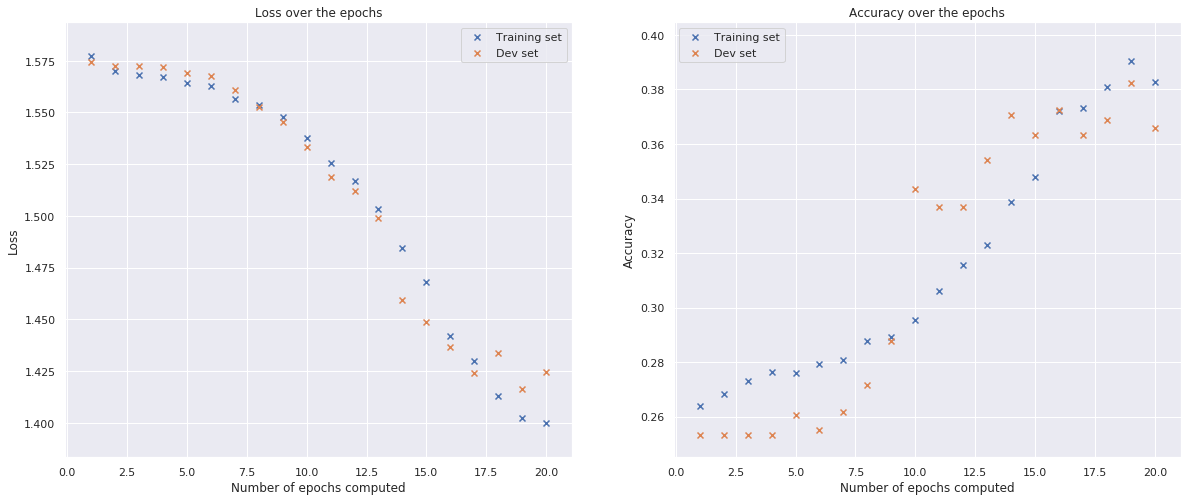

In [32]:
# Plotting of the train/dev results according to the epochs
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Data
x_epochs = [i+1 for i in range(n_epochs)]
y_train_loss = history.history['loss']
y_train_accuracy = history.history['acc']
y_dev_loss = history.history['val_loss']
y_dev_accuracy = history.history['val_acc']

# Scattering of the data
axs[0].scatter(x_epochs, y_train_loss, marker="x", label="Training set")
axs[0].scatter(x_epochs, y_dev_loss, marker="x", label="Dev set")

axs[1].scatter(x_epochs, y_train_accuracy, marker="x", label="Training set")
axs[1].scatter(x_epochs, y_dev_accuracy, marker="x", label="Dev set")

# Legend and Grid
for i in range(2):
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlabel("Number of epochs computed")

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].set_title("Loss over the epochs")
axs[1].set_title("Accuracy over the epochs")

# Save figure
fig.savefig("./Results/Loss_and_Accuracy_over_time.eps", bbox_inches='tight',
            pad_inches=0, dpi=200)

# Show
fig.show()

In [33]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# Predict the labels for the testing set with the best parameters found
Y_pred = model.predict(X_test_preprocessed_pad)

# Save the labels predicted in an array
np.savetxt("./Results/logreg_lstm_y_test_sst.txt", Y_pred, delimiter=",")

## 4.3 -- innovate !

In [34]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
# We use the impletention done here: 
# https://github.com/TobiasLee/Text-Classification/blob/master/models/attn_bi_lstm.py

In [ ]:
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.rnn import BasicLSTMCell
from utils.prepare_data import *
import time
from utils.model_helper import *


class ABLSTM(object):
    def __init__(self, config):
        
        tf.reset_default_graph()
        
        self.max_len = config["max_len"]
        self.hidden_size = config["hidden_size"]
        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.n_class = config["n_class"]
        self.learning_rate = config["learning_rate"]

        # placeholder
        self.x = tf.placeholder(tf.int32, [None, self.max_len])
        self.label = tf.placeholder(tf.int32, [None])
        self.keep_prob = tf.placeholder(tf.float32)
        
        

    def build_graph(self):
        print("building graph")
        # Word embedding
        embeddings_var = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                                     trainable=True)
        
        batch_embedded = tf.nn.embedding_lookup(embeddings_var, self.x)

        rnn_outputs, _ = bi_rnn(BasicLSTMCell(self.hidden_size),
                                BasicLSTMCell(self.hidden_size),
                                inputs=batch_embedded, dtype=tf.float32)

        fw_outputs, bw_outputs = rnn_outputs

        W = tf.Variable(tf.random_normal([self.hidden_size], stddev=0.1))
        H = fw_outputs + bw_outputs  # (batch_size, seq_len, HIDDEN_SIZE)
        M = tf.tanh(H)  # M = tanh(H)  (batch_size, seq_len, HIDDEN_SIZE)

        self.alpha = tf.nn.softmax(tf.reshape(tf.matmul(tf.reshape(M, [-1, self.hidden_size]),
                                                        tf.reshape(W, [-1, 1])),
                                              (-1, self.max_len)))  # batch_size x seq_len
        r = tf.matmul(tf.transpose(H, [0, 2, 1]),
                      tf.reshape(self.alpha, [-1, self.max_len, 1]))
        r = tf.squeeze(r)
        h_star = tf.tanh(r)  # (batch , HIDDEN_SIZE

        h_drop = tf.nn.dropout(h_star, self.keep_prob)

        # Fully connected layer（dense layer)
        FC_W = tf.Variable(tf.truncated_normal([self.hidden_size, self.n_class], stddev=0.1))
        FC_b = tf.Variable(tf.constant(0., shape=[self.n_class]))
        y_hat = tf.nn.xw_plus_b(h_drop, FC_W, FC_b)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_hat, labels=self.label))

        # prediction
        self.prediction = tf.argmax(tf.nn.softmax(y_hat), 1)

        # optimization
        loss_to_minimize = self.loss
        tvars = tf.trainable_variables()
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        grads, global_norm = tf.clip_by_global_norm(gradients, 1.0)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars), global_step=self.global_step,
                                                       name='train_step')
        print("graph built successfully!")


if __name__ == '__main__':
    # load data
    x_train, y_train = X_train, Y_train
    x_dev, y_dev = X_dev, Y_dev

    # data preprocessing
    x_train, x_dev, vocab_size = \
        data_preprocessing_v2(x_train, x_dev, max_len=32)
    print("train size: ", len(x_train))
    print("vocab size: ", vocab_size)

    # split dataset to test and dev

    config = {
        "max_len": 32,
        "hidden_size": 32,
        "vocab_size": vocab_size,
        "embedding_size": 3,
        "n_class": 5,
        "learning_rate": 1e-3,
        "batch_size": 4,
        "train_epoch": 15
    }

    classifier = ABLSTM(config)
    classifier.build_graph()

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    dev_batch = (x_dev, y_dev)
    start = time.time()
    for e in range(config["train_epoch"]):

        t0 = time.time()
        print("Epoch %d start !" % (e + 1))
        for x_batch, y_batch in fill_feed_dict(x_train, y_train, config["batch_size"]):
            return_dict = run_train_step(classifier, sess, (x_batch, y_batch))
            attn = get_attn_weight(classifier, sess, (x_batch, y_batch))
            # plot the attention weight
            # print(np.reshape(attn, (config["batch_size"], config["max_len"])))
        t1 = time.time()

        print("Train Epoch time:  %.3f s" % (t1 - t0))
        dev_acc = run_eval_step(classifier, sess, dev_batch)
        print("validation accuracy: %.3f " % dev_acc)

    print("Training finished, time consumed : ", time.time() - start, " s")

train size:  8544
vocab size:  50002
building graph
graph built successfully!
Epoch 1 start !


In [ ]:
# Predict the labels for the testing set with the best parameters found
x_test, x_dev, vocab_size = data_preprocessing_v2(X_test, X_dev, max_len=32)

feed_dict = feed_dict = {classifier.x: x_test,
                         classifier.label: [0 for i in x_test],
                         classifier.keep_prob: 1.0}
Y_pred = sess.run(classifier.prediction, feed_dict)

# Save the labels predicted in an array
np.savetxt("./Results/XXX_XXX_y_test_sst.txt", Y_pred, delimiter=",")